In [1]:


# folder with pictures
ROOT_DIR = r'D:\Projekt'
ROOT_DIR2 = r'D:\Projekt_val'
# dir to csv files
dir = r"C:\Users\Shadow\Documents\sequentialmodel - Kopie\preprocess"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
#from torchsummary import summary
from torch.optim import lr_scheduler


# Dataset
from GeoGuessrDataset import GeoGuessrDataset


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange
import time
import copy
import pygeohash as phg


%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [3]:
# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)


cuda:0


In [4]:
# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights


In [5]:
"""
import pygeohash as phg


df = pd.read_csv(dir+"\coordinates.csv", delimiter=',', skiprows=0, low_memory=False)

# We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)


def geohash_to_decimal(geohash):
    base_32 = '0123456789bcdefghjkmnpqrstuvwxyz';
    geohash = geohash.lower()
    return sum([32**idx * base_32.index(char) for idx, char in enumerate(geohash[::-1])])

df['geohash_decimal']=df.apply(lambda x: geohash_to_decimal(x["geohash"]) ,axis=1)

geohashes_with_samples = df["geohash_decimal"].unique()
print("Number of geohashes with samples", len(geohashes_with_samples))

geohash_map = { geo: i for i, geo in enumerate(geohashes_with_samples)}

df["geo_code"] = df.apply(lambda geohash: geohash_map[geohash["geohash_decimal"]], axis=1)

df[["filename", "latitude","longitude", "geohash_decimal", "geo_code"]].to_csv(dir+"\coordinates2.csv", index=False)

# Add geohash center coordinates to csv

def geohash_center(geohash_name):

    # Decode the geohash to get the center coordinates and errors.
    latitude, longitude, latitude_error, longitude_error = phg.decode_exactly(geohash_name)
    return [latitude, longitude]

df["geo_lat"], df["geo_lon"] = df.apply(lambda x: geohash_center(x["geohash"])[0] ,axis=1), df.apply(lambda x: geohash_center(x["geohash"])[1] ,axis=1)

# drop the duplicates
df = df.drop(columns=["filename", "latitude", "longitude","geohash_decimal","geohash"] )
df = df.drop_duplicates()
array = df.to_numpy()
array = np.array(array, dtype=np.float64)
tensor = torch.tensor(array)
torch.save(tensor, dir+'\\tensor.pt')
# Save the DataFrame to a CSV file.
df[["geo_code", "geo_lat", "geo_lon"]].to_csv(dir+"\coords_center.csv", index=False)
"""

'\nimport pygeohash as phg\n\n\ndf = pd.read_csv(dir+"\\coordinates.csv", delimiter=\',\', skiprows=0, low_memory=False)\n\n# We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.\ndf[\'geohash\']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)\n\n\ndef geohash_to_decimal(geohash):\n    base_32 = \'0123456789bcdefghjkmnpqrstuvwxyz\';\n    geohash = geohash.lower()\n    return sum([32**idx * base_32.index(char) for idx, char in enumerate(geohash[::-1])])\n\ndf[\'geohash_decimal\']=df.apply(lambda x: geohash_to_decimal(x["geohash"]) ,axis=1)\n\ngeohashes_with_samples = df["geohash_decimal"].unique()\nprint("Number of geohashes with samples", len(geohashes_with_samples))\n\ngeohash_map = { geo: i for i, geo in enumerate(geohashes_with_samples)}\n\ndf["geo_code"] = df.apply(lambda geohash: geohash_map[geohash["geohash_decimal"]], axis=1)\n\ndf[["filename", "latitude","longitude", "geohash_deci

## Create training and val csv after applying split in folder structure

In [6]:

import os
df_csv = pd.read_csv(dir+"\coordinates2.csv", delimiter=',', skiprows=0, low_memory=False)

df_filenames_train = pd.DataFrame({'filename': [f for f in os.listdir(ROOT_DIR)]})
df_filenames_val = pd.DataFrame({'filename': [f for f in os.listdir(ROOT_DIR2)]})

df_filtered_train = pd.merge(df_csv, df_filenames_train, on='filename')
df_filtered_val = pd.merge(df_csv, df_filenames_val, on='filename')

df_filtered_train.to_csv(dir+"\\train.csv", index=False)
df_filtered_val.to_csv(dir+"\\val.csv", index=False)


In [7]:
"""
df = pd.read_csv(dir+"\\final_contis_merged.csv", delimiter=',', skiprows=0, low_memory=False)

def encode_geohashes(df, continent_name = None, drop_some = False):
    
    if continent_name:
        # get csv to only contain one continent
        keys = df["continent"].unique()
        indices = {key: df.index[df["continent"]==key].tolist()for key in keys}
        df = df.iloc[indices[continent_name]]

        # We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
        df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)

        # get all hashes that contain samples
        geohashes_with_samples = df["geohash"].unique()                 
        num_geohashes_with_samples = len(geohashes_with_samples)
        print("Number of geohashes with samples", num_geohashes_with_samples)
        
        # test for dropping geohashes that contain less than 3 samples
        if drop_some == True:
            counts = df["geohash"].value_counts()
            to_drop = counts[counts>=3].index
            print("number of geohashes with 3 or more samples:", len(to_drop))
            df= df[df["geohash"].isin(to_drop)]
            geohashes_with_samples = df["geohash"].unique()
            num_geohashes_with_samples = len(geohashes_with_samples)
            
        # map the geohashes with samples to cluster_numbers
        geohash_map = { geo: i for i, geo in enumerate(geohashes_with_samples)}
        df["geo_code"] = df.apply(lambda geohash: geohash_map[geohash["geohash"]], axis=1)

        # those values are not needed, but we have to keep the number of columns the same for the dataloader
        df["geohash_decimal"] = np.nan
        
    else:
        num_geohashes_with_samples = len(df["geo_code"].unique())
        
        # We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
        df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)
        
        print("Number of geohashes with samples", num_geohashes_with_samples)
        
    # save as csv
    df[["filename", "latitude", "longitude", "geohash_decimal", "geo_code", "continent", "conti_code"]].to_csv(dir+"\coordinates3.csv", index=False)
    
    return df, num_geohashes_with_samples

# create another csv with the coordinates of the centers of each geohash
def geohash_center(geohash_name):

    # Decode the geohash to get the center coordinates and errors.
    latitude, longitude, latitude_error, longitude_error = phg.decode_exactly(geohash_name)
    return [latitude, longitude]




# encode geohashes for chosen continent (ommit continent and drop_some if we want to train all data)
df, fc_size = encode_geohashes(df, drop_some = False)

# compute the center coordinates of each geohash
df["geo_lat"], df["geo_lon"] = df.apply(lambda x: geohash_center(x["geohash"])[0] ,axis=1), df.apply(lambda x: geohash_center(x["geohash"])[1] ,axis=1)

# drop the duplicates
df = df.drop(columns=["filename", "latitude", "longitude","geohash_decimal","geohash", "continent", "conti_code"] )
df = df.drop_duplicates()

# do we use the tensor?
array = df.to_numpy()
array = np.array(array, dtype=np.float64)
tensor = torch.tensor(array)
torch.save(tensor, dir+'\\tensor.pt')

# Save the DataFrame to a CSV file.
df[["geo_code", "geo_lat", "geo_lon"]].to_csv(dir+"\coords_center.csv", index=False)

"""

'\ndf = pd.read_csv(dir+"\\final_contis_merged.csv", delimiter=\',\', skiprows=0, low_memory=False)\n\ndef encode_geohashes(df, continent_name = None, drop_some = False):\n    \n    if continent_name:\n        # get csv to only contain one continent\n        keys = df["continent"].unique()\n        indices = {key: df.index[df["continent"]==key].tolist()for key in keys}\n        df = df.iloc[indices[continent_name]]\n\n        # We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.\n        df[\'geohash\']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)\n\n        # get all hashes that contain samples\n        geohashes_with_samples = df["geohash"].unique()                 \n        num_geohashes_with_samples = len(geohashes_with_samples)\n        print("Number of geohashes with samples", num_geohashes_with_samples)\n        \n        # test for dropping geohashes that contain less than 3 s

### Different augementations that have been testet / collection of sample distribution for stratified sampling

In [8]:
from torch.utils.data import WeightedRandomSampler

"""
# Define the data transformation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop((512,1536)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((250, 1000))
])
"""
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((250, 1000))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((250, 1000))
])

# Load the dataset and split it into training and validation sets (fc_size is generated in the kernel above)
train_dataset = GeoGuessrDataset(csv_file=dir+'\\train.csv',
                                    root_dir=ROOT_DIR, transform=train_transform, num_classes=3789, indices=None)
val_dataset = GeoGuessrDataset(csv_file=dir+'\\val.csv',
                                    root_dir=ROOT_DIR2, transform=val_transform, num_classes=3789, indices=None)

"""
class_weights = [0] * 3789
for idx, x in enumerate(train_dataset):
    
    class_weights[torch.argmax(x['geohash'])] += 1
    if idx % 5000 == 0:
        print('1...',idx)
    #if idx == 500:
        #break
t = np.zeros(3789)
t[np.array(class_weights) > 0] = 1
class_weights = t / np.array(class_weights)    
    
sample_weights = [0] * len(train_dataset)

for idx, x in enumerate(train_dataset):
    
    class_weight = class_weights[torch.argmax(x['geohash'])]
    sample_weights[idx] = class_weight
    if idx % 5000 == 0:
        print('2...',idx)
    #if idx == 500:
        #break
"""
check = torch.load(r"C:\Users\Shadow\Documents\sequentialmodel - Kopie\sampe_weights.tar")
sample_weights = check['sample_weights']
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
#train_size = int(0.9 * len(dataset))
#val_size = len(dataset) - train_size
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],generator=torch.Generator(
#).manual_seed(42))
#print(len(train_dataset))
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4, pin_memory=True)
#train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

train_size = len(train_dataset)
val_size = len(val_dataset)

dataloaders = {"train" : train_dataloader, "val": val_dataloader}
dataset_sizes = {"train": train_size, "val" : val_size}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Sanity check for sampling

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


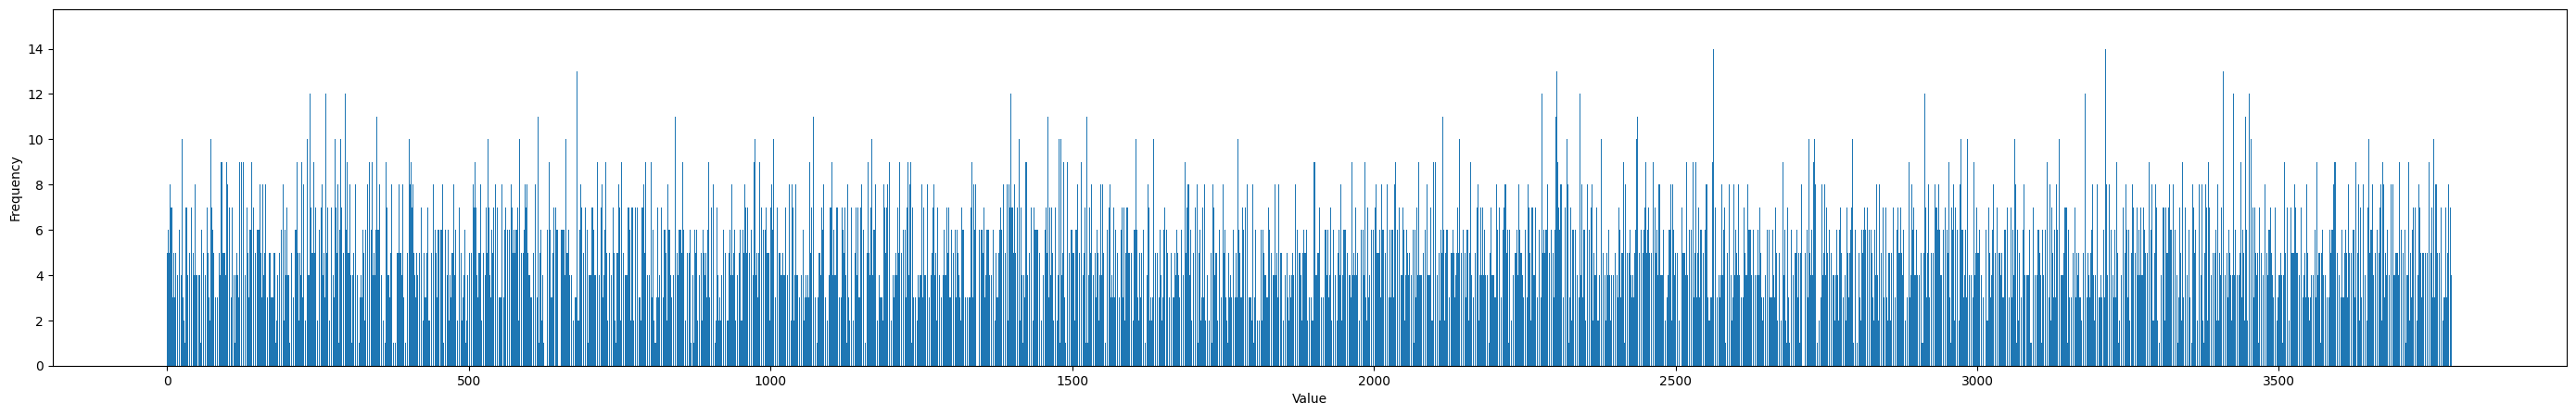

[5 3 6 ... 4 5 8]


In [9]:

elements = []
for epoch in range(2):
    for idx, x in enumerate(train_dataloader):
        elements.append(torch.argmax(x['geohash']))
        if idx % 500 ==0:
            print(idx)
        if idx ==9500:
            break
plot = np.bincount(np.array(elements),minlength=3789)

values = np.arange(len(plot))
    
    
plt.figure(figsize=(35, 5))
# Create the histogram using matplotlib

plt.bar(values, plot)
plt.xlabel('Value')
plt.ylabel('Frequency')
# Add labels and show the plot
plt.show()
print(plot)


In [10]:
#torch.save({'sample_weights':sample_weights,'class_weights':class_weights},r"C:\Users\Shadow\Documents\sampe_weights.tar")

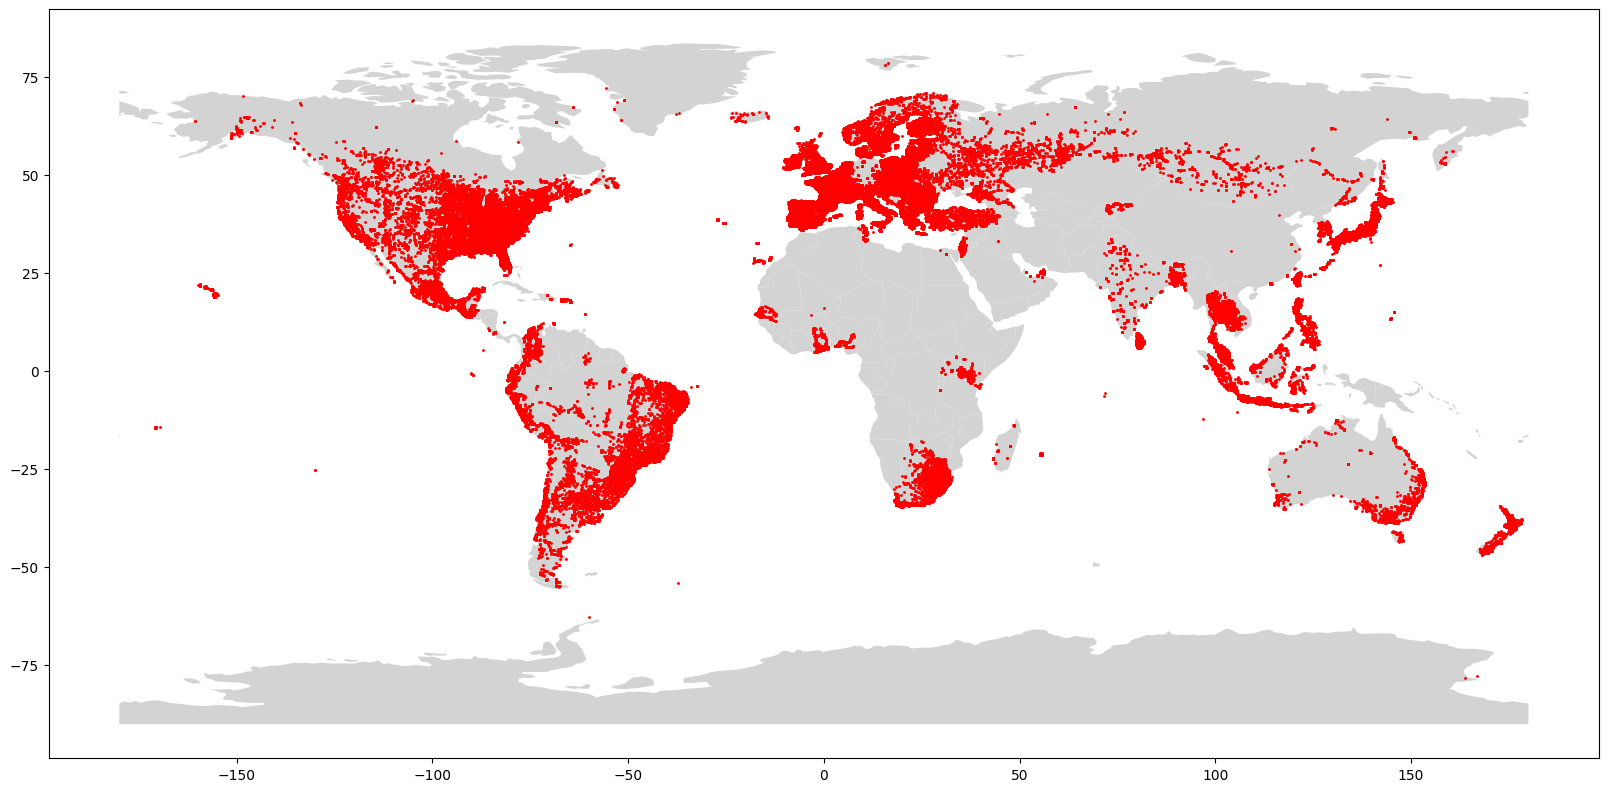

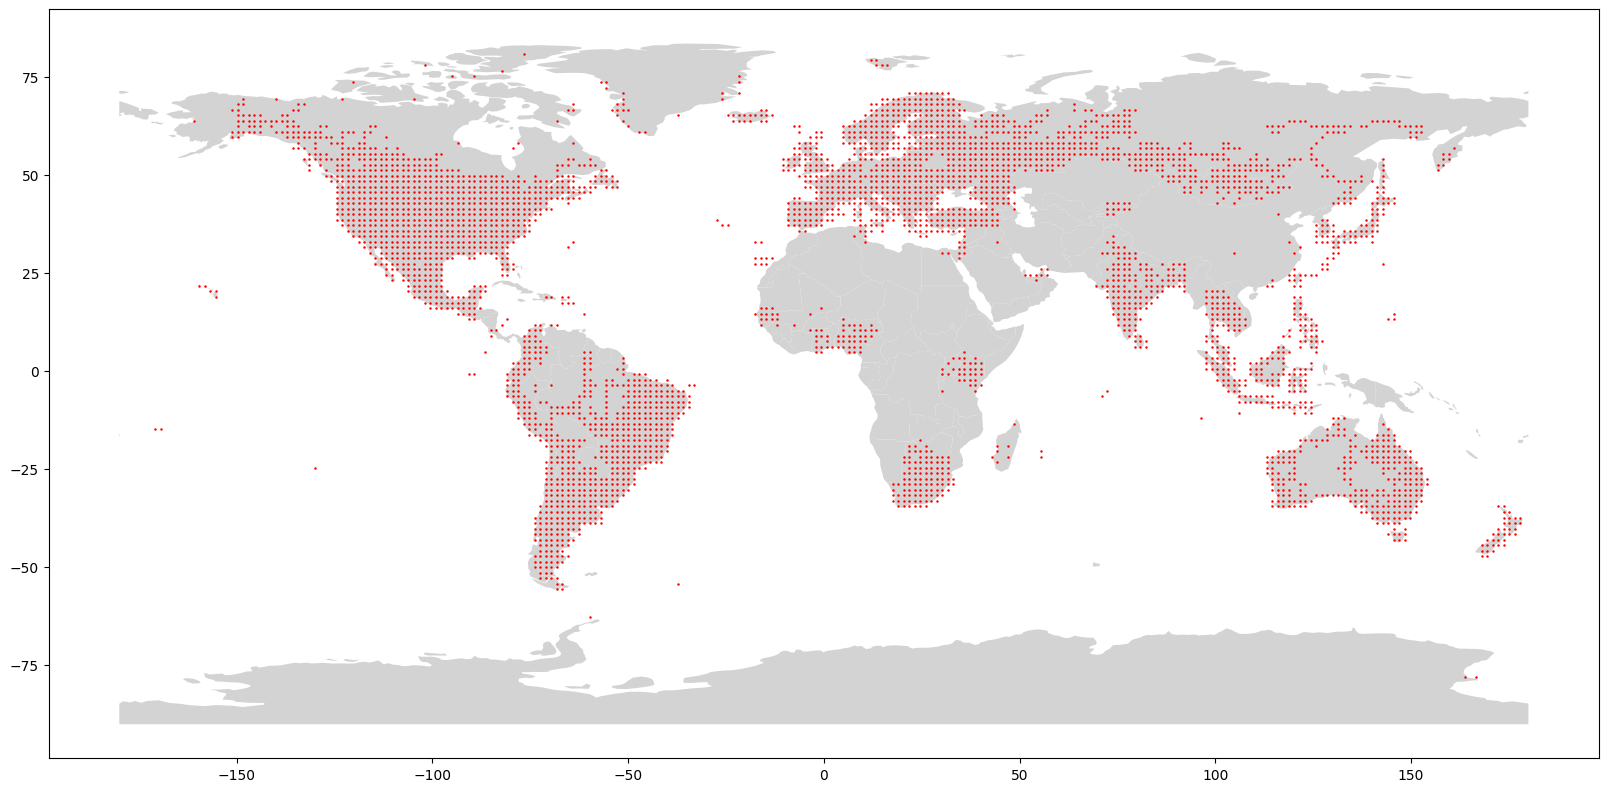

In [11]:
import geopandas as gpd
plt.rcParams["figure.dpi"] = 100

df = pd.read_csv(dir+"\\coordinates3.csv", delimiter=',', skiprows=0, low_memory=False)

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))


countries.plot(color="lightgrey", figsize = (20, 16))


plt.scatter(df["longitude"], df["latitude"], c='red', s = 0.6)
plt.show()

df = pd.read_csv(dir+"\\coords_center.csv", delimiter=',', skiprows=0, low_memory=False)

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))


countries.plot(color="lightgrey", figsize = (20, 16))


plt.scatter(df["geo_lon"], df["geo_lat"], c='red', s = 0.6)
plt.show()


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    torch.backends.cudnn.benchmark = True
    
    best_acc = 0.0
     
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    epoch_dist = []
    
    ######################
    # single batch test
    #batch=next(iter(dataloaders["train"]))
    
    ##############################
    for epoch in (pbar := tnrange(num_epochs)):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_dist = 0.0
            # Iterate over data.
            for idx, batch in enumerate(dataloaders[phase]):
                inputs, labels, gt  = batch["image"], batch["geohash"], batch['gt']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)


                    ##########################################################
                    # loss switch :
                    # first line Haversine + CE
                    #second line benchmark
                    # third line cross entropy
                    #either use line 1 or 3
                    loss = criterion(outputs, gt, labels)

                    #loss = criterion2(outputs, labels.float())

                    ##########################################################
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        optimizer.step()
                    _,labels = torch.max(labels, 1)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_dist += criterion1(outputs, gt, labels).item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            if phase == 'train':
                scheduler.step()
            
            ################################################
            #adjust for single batch testing
            #epoch_distance = running_dist / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            ###############################################################
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Dist: ')

            
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
             # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                PATH3 = r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_Hav_Aug_Google_StratSamp.tar"
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'val_loss_history': val_loss_history,
                'val_acc_history': val_acc_history,
                'train_loss_history' : train_loss_history,
                'train_acc_history' : train_acc_history
                }, PATH3)

        print()
    
    PATH3 = r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_Hav_Aug_Google_StratSamp_stats.tar"
    torch.save({
    'val_loss_history': val_loss_history,
    'val_acc_history': val_acc_history,
    'train_loss_history' : train_loss_history,
    'train_acc_history' : train_acc_history
    }, PATH3)

    
    print(f'Best val Acc: {best_acc:4f}')

    
    return model

## Haversine Loss

In [13]:
import math
def haversine_loss(lons1, lats1, lons2, lats2):
    """
    Calculate the Haversine distance between two sets of longitudes and latitudes.

    Parameters:
        - lons1 (torch.tensor): Tensor of longitudes for the first set of points.
        - lats1 (torch.tensor): Tensor of latitudes for the first set of points.
        - lons2 (torch.tensor): Tensor of longitudes for the second set of points.
        - lats2 (torch.tensor): Tensor of latitudes

    Returns:
        - distances (torch.tensor): Tensor of Haversine distances.
    """
    # Convert longitudes and latitudes to radians.
    lons1 = lons1.to(torch.float) * math.pi / 180
    lats1 = lats1.to(torch.float) * math.pi / 180
    lons2 = lons2.to(torch.float) * math.pi / 180
    lats2 = lats2.to(torch.float) * math.pi / 180

    # Calculate differences in longitudes and latitudes.
    dlons = lons2 - lons1
    dlats = lats2 - lats1

    # Calculate intermediate values.
    a = (torch.sin(dlats / 2)**2) + (torch.cos(lats1) * torch.cos(lats2) * (torch.sin(dlons / 2)**2))
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

    # Calculate distances.
    R = 6371  # Earth radius in kilometers
    distances = R * c

    return distances

In [14]:

# custom loss that transforms the predicted cluster and the ground truth label into coordinates
# and then computes the haversine distance between them as loss combined with cross entropy loss


class HaversineLoss_CE(torch.nn.Module):
    def __init__(self):
        super(HaversineLoss_CE, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output, gt, labels):
        """
            output: (batchsize, num_clusters) Tensor with probabillities
            gt: tupel contains groundtruth lat, lon
        """

        
        tensor = torch.load(dir+'\\tensor.pt')
        # Extract the latitude and longitude from the predicted location.
        #lat_cluster, lon_cluster = torch.zeros(len(output)), torch.zeros(len(output))
        lat_cluster, lon_cluster = tensor[:,1], tensor[:,2]

        # Calculate the Haversine distance between the predicted and target locations.
        gt0 = torch.tensor(gt[:,0])
        gt1 = torch.tensor(gt[:,1])
        
        distance = haversine_loss(lat_cluster, lon_cluster, gt0[:,None], gt1[:,None])
        #print(torch.argmin(distance,dim=1))    
        
        
        output1 = F.softmax(output, dim=1)
        
        # Return the loss.
        distance = distance.to(device)
        #print(torch.sum(distance*output,dim=1))
        
        loss = torch.mean(torch.sum(distance*output1,dim=1)) + 10000 * self.criterion(output, labels.float())

        return loss


In [15]:
# used as another benchmark value



class HaversineLoss(torch.nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output, gt, labels):
        """
            output: (batchsize, num_clusters) Tensor with probabillities
            gt: tupel contains groundtruth lat, lon
        """

        
        tensor = torch.load(dir+'\\tensor.pt')
        # Extract the latitude and longitude from the predicted location.
        #lat_cluster, lon_cluster = torch.zeros(len(output)), torch.zeros(len(output))
        lat_cluster, lon_cluster = tensor[:,1], tensor[:,2]

        # Calculate the Haversine distance between the predicted and target locations.
        gt0 = torch.tensor(gt[:,0])
        gt1 = torch.tensor(gt[:,1])
        
        distance = haversine_loss(lat_cluster, lon_cluster, gt0[:,None], gt1[:,None])
        #print(torch.argmin(distance,dim=1))    
        
        
        output1 = F.softmax(output, dim=1)
        
        # Return the loss.
        distance = distance.to(device)
        #print(torch.sum(distance*output,dim=1))
        
        loss = torch.mean(torch.sum(distance*output1,dim=1)) #+ 10000 * self.criterion(output, labels.float())

        return loss


In [16]:
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs,3789)


model_ft = model_ft.to(device)

#checkpoint = torch.load(r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_all_Hav_Aug_Google_StratSamp.tar")
#model_ft.load_state_dict(checkpoint['model_state_dict'])
 
criterion = HaversineLoss_CE()
criterion1 = HaversineLoss()
criterion2 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001)
#optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
# Decay LR by a factor of 0.5 every 6 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.5)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8
----------


C:\Users\Shadow\AppData\Local\Temp\ipykernel_35940\2087366516.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt0 = torch.tensor(gt[:,0])
C:\Users\Shadow\AppData\Local\Temp\ipykernel_35940\2087366516.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt1 = torch.tensor(gt[:,1])


In [ ]:
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3789)

model_ft = model_ft.to(device)



In [ ]:
from utils import show_training
checkpoint = torch.load(r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_all_Hav_Aug_Google_StratSamp_stats.tar")

history = {'loss':checkpoint['train_loss_history'], 'train_acc':checkpoint['train_acc_history'],'val_acc':checkpoint['val_acc_history']}

show_training(history)